In [12]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
root_path = 'C:\\Users\\User\\Desktop\\LocomotionData'
os.chdir(root_path)
fileList = os.listdir()
filenames = []
for filename in fileList:
    if filename[-1] == 't':
        filenames.append(filename)
print(filenames)

['1141928.txt', '315928.txt', '337928.txt', '338928.txt', '339928.txt', '354928.txt', '357928.txt', '358928.txt', '41928.txt', '45928.txt', '4928.txt', '843928.txt', '844928.txt', '846928.txt', '849928.txt', '850928.txt', '852928.txt', '854928.txt', '856928.txt', '857928.txt', 'bb.txt', 'cc.txt', 'FinalDAtool.txt', 'm100.txt', 'm97.txt', 'm98.txt', 'm99.txt', 'mah243928.txt', 'mah248928.txt', 'mah258928.txt', 'mah259928.txt', 'mah306928.txt', 'mah307928.txt', 'mah313928.txt', 'mah314928.txt', 'mah3928.txt', 'mahf27.txt', 'mahfuz27.txt', 'mahfuz928829.txt', 'mahfuzRayhan27.txt', 'mm.txt', 'mmr242928.txt', 'n.txt', 'n414928.txt', 'n416928.txt', 'n419928.txt', 'n420928.txt', 'n421928.txt', 'n428928.txt', 'n430928.txt', 'n47928.txt', 'nn.txt', 's65928.txt', 'safin.txt', 'teat.txt', 'test.txt']


In [68]:
def process_text_file(name, naam):
    raw_filename = name
    #print(raw_filename)
    processed_filename = re.sub(r'(txt)', 'csv', raw_filename)
    #print(processed_filename)
    raw_filepath = os.path.join(root_path, raw_filename)
    processed_filepath = os.path.join(root_path, processed_filename)

    keys = ['time', 'thigh', 'shank', 'foot', 'axesoris'] 
    cleaner = re.compile(r'[CTSFA:<>]')
    regs = {
        'time' : re.compile(r'(C: <.*?>)'),
        'thigh' : re.compile(r'(T: <.*?>)'), 
        'shank' : re.compile(r'(S: <.*?>)'), 
        'foot' : re.compile(r'(F: <.*?>)'), 
        'axesoris' : re.compile(r'(A: <.*?>)')
    } 
    segments = {
        'time' : "",
        'thigh' : "",
        'shank' : "",
        'foot' : "",
        'axesoris' : ""
    }
    num_segments = {
        'time' : [], 
        'thigh' : [],
        'shank' : [],
        'foot' : [],
        'axesoris' : []
    }
    
    with open(processed_filepath, "w") as processed_file:
        processed_file.write("Hours,Minute,Seconds,Thigh_AccX,Thigh_AccY,Thigh_AccZ,ThighGyX,ThighGyY,ThighGyZ,ShankAccX,ShankAccY,ShankAccZ,ShankGyX,ShankGyY,ShankGyZ,FootAccX,FootAccY,FootAccZ,FootGyX,FootGyY,FootGyZ,HeelSwitch,ToeSwitch,KneePot,AnklePot,ModeIndicator\n")
        try:
            with open(raw_filepath, 'r') as raw_file:
                i = 1
                for line in raw_file:
                    packet = line.strip()
                    #if i != 1:
                        #processed_file.write(str(i-1)+",")
                    for key in keys:
                        temp = regs[key].search(packet)
                        if temp is not None:
                            segments[key] = temp.group()
                            segments[key] = re.sub(cleaner, "", segments[key])
                            separated_val = segments[key].split()
                            num_segments[key] = []
                            for word in separated_val:
                                num = int(word)
                                num_segments[key].append(num)
                                processed_file.write(word+",")
                            #print("Line %d: source: %s, data: %s" %(i, key, num_segments[key]))
                        else:
                            print("missing or unformatted %s data at line %d"%(key, i))
                    if i != 1:
                        processed_file.write("\n")
                    i= i+1     
        except FileNotFoundError:
            print(f"The file '{raw_filepath}' does not exist.")
        except Exception as e:
            print(f"An error occurred: {e}")

#Read ModeIndicator
    df = pd.read_csv(processed_filepath, index_col = False)
    arr = df.values
    prev_val = arr[:, -1]
    [np.size(arr[1,:]), np.size(arr[:,1])]
    modeIndicator = arr[:,-1]
    l = len(modeIndicator)
#Remove extra elements only keeping the first occurance 
    i = 1
    interim = []
    interim.append(0)
    while i < l:
        dif = modeIndicator[i] - modeIndicator[i-1]
        if dif == 1:
            interim.append(1)
        else:
            interim.append(0)
        i = i+1
#Keep incrementing at every occurence
    i = 0
    state = -1
    Mode = []
    while i < l:
        if interim[i]:
            state = state + 1
        Mode.append(state)
        i=i+1
    
    df = df.drop('ModeIndicator', axis=1)
    df['Mode'] = Mode
    mode = df['Mode'].to_numpy()
    print(len(mode))
    for i in range(len(mode)):
        if mode[i] == -1:
            df = df.drop(i)
#             print('dropped row number %d'%i)
    mode = df['Mode'].to_numpy()
    print(len(mode))
    i = len(mode) 
    temp = mode[-1]
    print(temp)
    for i in range(len(mode)-1, -1, -1):
        if mode[i] == temp:
            df = df.drop(i)
#             print('dropped row number %d'%i)
    mode = df['Mode'].to_numpy()
    print(len(mode))
    i=0
    for i in range(0,len(mode)):
        mode[i] = mode[i] % 8
    print(len(mode))
    mode = df['Mode'].to_numpy()
    for i in range(len(mode)):
        if mode[i] == 0:
            mode[i] = 0
        if mode[i] == 1:
            mode[i] = 3
        if mode[i] == 2:
            mode[i] = 0
        if mode[i] == 3:
            mode[i] = 3
        if mode[i] == 4:
            mode[i] = 0
        if mode[i] == 5:
            mode[i] = 2
        if mode[i] == 6:
            mode[i] = 0
        if mode[i] == 7:
            mode[i] = 2
        
    heel = df['HeelSwitch']
    toe = df['ToeSwitch']
    phase = []
    for i, j in zip(heel, toe):
        phase.append(i or j)
    mode = df['Mode']
#     df = df.drop('HeelSwitch', axis = 1)
#     df = df.drop('ToeSwitch', axis = 1)
    df = df.drop('Mode', axis = 1)
    df['Phase'] = phase
    df['Mode'] = mode
    df.to_csv(processed_filepath, index=False)
    naam = processed_filepath
    return naam

In [ ]:
def process_csv_file:
    #Read ModeIndicator
    df = pd.read_csv(processed_filepath, index_col = False)
    arr = df.values
    prev_val = arr[:, -1]
    [np.size(arr[1,:]), np.size(arr[:,1])]
    modeIndicator = arr[:,-1]
    l = len(modeIndicator)
#Remove extra elements only keeping the first occurance 
    i = 1
    interim = []
    interim.append(0)
    while i < l:
        dif = modeIndicator[i] - modeIndicator[i-1]
        if dif == 1:
            interim.append(1)
        else:
            interim.append(0)
        i = i+1
#Keep incrementing at every occurence
    i = 0
    state = -1
    Mode = []
    while i < l:
        if interim[i]:
            state = state + 1
        Mode.append(state)
        i=i+1
    
    df = df.drop('ModeIndicator', axis=1)
    df['Mode'] = Mode
    mode = df['Mode'].to_numpy()
    print(len(mode))
    for i in range(len(mode)):
        if mode[i] == -1:
            df = df.drop(i)
#             print('dropped row number %d'%i)
    mode = df['Mode'].to_numpy()
    print(len(mode))
    i = len(mode) 
    temp = mode[-1]
    print(temp)
    for i in range(len(mode)-1, -1, -1):
        if mode[i] == temp:
            df = df.drop(i)
#             print('dropped row number %d'%i)
    mode = df['Mode'].to_numpy()
    print(len(mode))
    i=0
    for i in range(0,len(mode)):
        mode[i] = mode[i] % 8
    print(len(mode))
    mode = df['Mode'].to_numpy()
    for i in range(len(mode)):
        if mode[i] == 0:
            mode[i] = 0
        if mode[i] == 1:
            mode[i] = 3
        if mode[i] == 2:
            mode[i] = 0
        if mode[i] == 3:
            mode[i] = 3
        if mode[i] == 4:
            mode[i] = 0
        if mode[i] == 5:
            mode[i] = 2
        if mode[i] == 6:
            mode[i] = 0
        if mode[i] == 7:
            mode[i] = 2
        
    heel = df['HeelSwitch']
    toe = df['ToeSwitch']
    phase = []
    for i, j in zip(heel, toe):
        phase.append(i or j)
    mode = df['Mode']
#     df = df.drop('HeelSwitch', axis = 1)
#     df = df.drop('ToeSwitch', axis = 1)
    df = df.drop('Mode', axis = 1)
    df['Phase'] = phase
    df['Mode'] = mode
    df.to_csv(processed_filepath, index=False)
    naam = processed_filepath
    return naam

In [53]:
def extract_feats(file, dest):
    pathname = os.path.dirname(file)
    filename = os.path.basename(file)
    feat_filename = "featsFrom_"+filename
    feat_file = os.path.join(pathname, feat_filename)
    df = pd.read_csv(file)
    df = df.drop('Hours', axis = 1)
    df = df.drop('Minute', axis = 1)
    df = df.drop('Seconds', axis = 1)
    phase = df['Phase'].to_numpy()
    print(len(phase))
    column_names = ['Thigh_AccX', 'Thigh_AccY', 'Thigh_AccZ', 'ThighGyX', 'ThighGyY', 'ThighGyZ', 'ShankAccX', 'ShankAccY',  'ShankAccZ', 'ShankGyX', 'ShankGyY', 'ShankGyZ', 'FootAccX', 'FootAccY', 'FootAccZ', 'FootGyX', 'FootGyY', 'FootGyZ', 'KneePot', 'AnklePot', 'Phase', 'Mode']
    feats = ['initial', 'final', 'minimum', 'maximum', 'mean', 'std_dev', 'rms']
    feat_cols = []
    for i in range(len(column_names)-2):
        for j in range(len(feats)):
            feat_cols.append(column_names[i]+'_'+feats[j])
    feat_cols.append('Mode')
    feature_df = pd.DataFrame(columns = feat_cols)
    k = 0
    count = 0
    flag = 0
    i = 0
    df_temp = pd.DataFrame(columns=column_names)
    # print('file initialization')
    for i in range(len(phase)):
        if phase[i] == 1:
            #print('pushing')
            df_temp.loc[k] = df.iloc[i].copy()
            k = k + 1
            flag = 0
    #         print(phase[i], i, k, flag, count)
        else:
            if flag == 0:
    #             print(df_temp.head)
                feature = []
    #             print('getting out')
                for j in range(len(column_names)-2):
                    arr = df_temp[column_names[j]].to_numpy()
                    l = [arr[0], arr[-1], arr.min(), arr.max(), arr.mean(), arr.std(), np.mean(np.square(arr))]
                    feature.extend(l)
                feature.extend([df_temp.iloc[-1, -1]])
                feature_df.loc[count] = feature; 
                count = count + 1
                k = 0
                flag = 1
                df_temp = pd.DataFrame(columns=column_names)
    #             print(feature)
    #             print(phase[i], i, k, flag, count)
            else:
    #             print(phase[i], i, k, flag, count)
                flag = 1
                continue
    feature_df.to_csv(feat_file, index = False)
#     print(file)
#     print(feature_df)
    return dest

In [76]:
filenames[49]

'n430928.txt'

In [77]:
filepath = process_text_file(filenames[49], "e")
# featfile = extract_feats(filepath, "e")
print(filepath, featfile)

missing or unformatted time data at line 1
missing or unformatted thigh data at line 1
missing or unformatted shank data at line 1
missing or unformatted foot data at line 1
missing or unformatted axesoris data at line 1
92234
82850
49
81972
81972
C:\Users\User\Desktop\LocomotionData\n430928.csv e


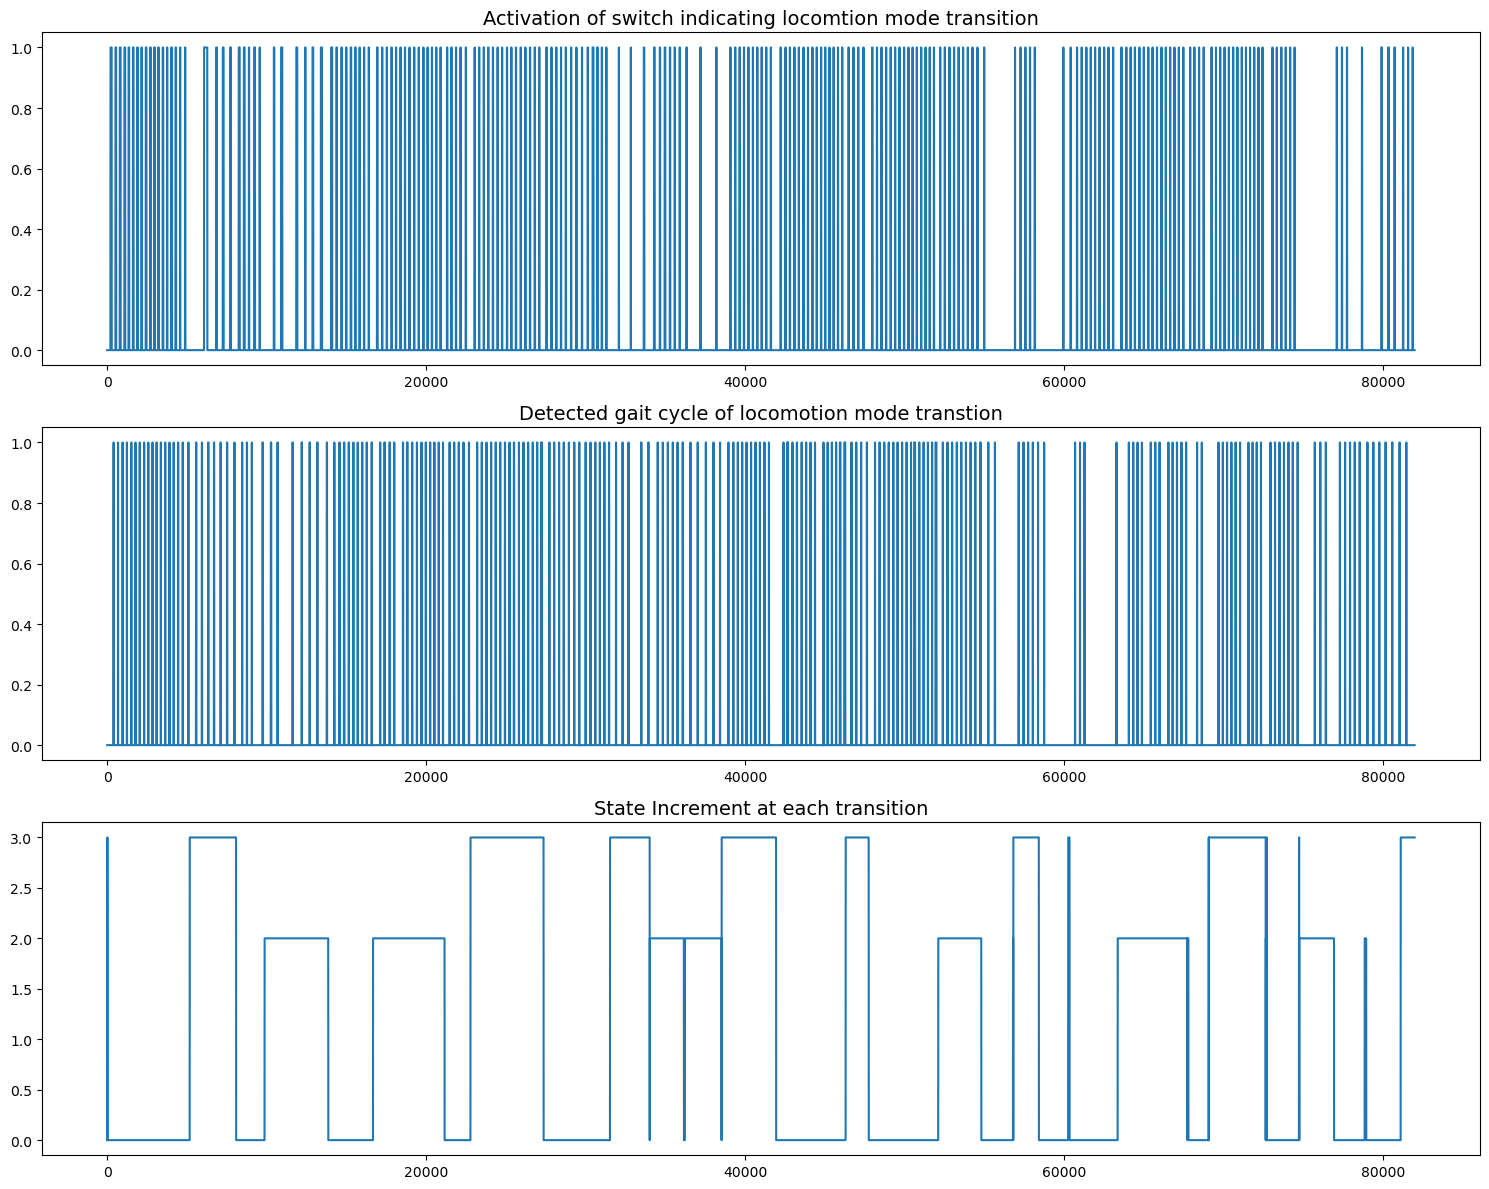

(0        0
 1        0
 2        0
 3        0
 4        0
         ..
 81967    0
 81968    0
 81969    0
 81970    0
 81971    0
 Name: HeelSwitch, Length: 81972, dtype: int64,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 81967    0
 81968    0
 81969    0
 81970    0
 81971    0
 Name: ToeSwitch, Length: 81972, dtype: int64,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 81967    3
 81968    3
 81969    3
 81970    3
 81971    3
 Name: Mode, Length: 81972, dtype: int64,
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [5]:
file = "C:\\Users\\User\\Desktop\\LocomotionData\\pn430928.csv"
df = pd.read_csv(file)
mode= df['Mode']

heel = df['HeelSwitch']
toe = df['ToeSwitch']
phase = []
for i,j in zip(heel, toe):
    phase.append(i or j)

df = df.drop('HeelSwitch', axis = 1) 
df = df.drop('ToeSwitch', axis = 1)
mode = df['Mode']
df = df.drop('Mode', axis = 1)
df['Phase'] = phase
df['Mode'] = mode

# Create a figure with 3 vertically stacked subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# Plot data on each subplot
ax1.plot(heel)
ax1.set_title('Activation of switch indicating locomtion mode transition', fontsize=14)

ax2.plot(toe)
ax2.set_title('Detected gait cycle of locomotion mode transtion', fontsize=14)

ax3.plot(mode)
ax3.set_title('State Increment at each transition', fontsize=14)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()
# df.to_csv(file)
heel, toe, mode, phase, i, j, df

In [11]:
hee_dif = 0
toe_dif = 0
l = len(heel)
heel_ind = []
toe_ind = []
for i in range(1,l):
    toe_dif = toe[i] - toe[i-1]
    heel_dif = heel[i] - heel[i-1]
    if toe_dif == 1:
        toe_ind.append(i-1)
    heel_dif = heel[i] - heel[i-1]
    if heel_dif == -1:
        heel_ind.append(i)
print(toe_ind) 
print(heel_ind)
for i in range(len(heel_ind)-1):
    print(i, end= " ")
    if heel_ind[i] < toe_ind[i] and heel_ind[i+1] > toe_ind[i]:
        print('%d %d %d'%(heel_ind[i], toe_ind[i], heel_ind[i+1]))
    else:
        print("%d skipped"%i, end = " ")
        print('%d %d %d'%(heel_ind[i], toe_ind[i], heel_ind[i+1]))

[393, 670, 958, 1229, 1504, 1764, 2033, 2309, 2569, 2835, 3090, 3360, 3633, 3898, 4162, 4438, 4730, 5080, 5563, 5926, 6318, 6686, 7097, 7504, 7965, 8452, 8752, 9063, 9726, 10252, 10663, 11607, 12180, 12676, 13152, 13759, 14230, 14552, 14839, 15137, 15423, 15700, 15980, 16264, 16566, 17105, 17369, 17694, 17984, 18533, 18786, 19112, 19410, 19692, 19964, 20236, 20500, 20777, 21045, 21458, 21740, 22035, 22332, 22670, 23182, 23473, 23768, 24060, 24351, 24631, 24927, 25215, 25490, 25806, 26086, 26381, 26673, 26941, 27190, 27711, 28011, 28322, 28622, 28939, 29269, 29583, 29989, 30293, 30592, 30879, 31161, 31453, 31893, 32299, 32682, 33468, 33909, 34504, 34830, 35140, 35452, 35751, 36067, 36556, 37014, 37521, 38000, 38414, 38937, 39247, 39530, 39803, 40078, 40358, 40641, 40915, 41200, 41486, 42390, 42627, 42675, 42955, 43228, 43536, 43813, 44087, 44368, 44899, 45162, 45425, 45691, 45929, 46206, 46649, 46956, 47264, 47617, 48131, 48415, 48707, 48991, 49276, 49540, 49830, 50108, 50387, 50586, 50

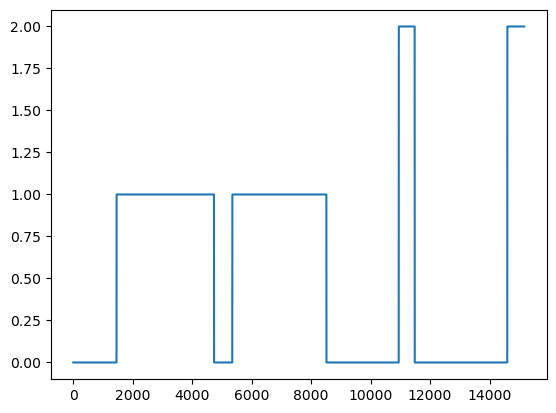

In [11]:
os.chdir(r'C:\Users\User\Desktop\LocomotionData')
df = pd.read_csv('kjk455.csv')
mode = df['Mode'].to_numpy()
plt.plot(mode)

In [45]:

        print(i)

15734
15733
15732
15731
15730
15729
15728
15727
15726
15725
15724
15723
15722
15721
15720
15719
15718
15717
15716
15715
15714
15713
15712
15711
15710
15709
15708
15707
15706
15705
15704
15703
15702
15701
15700
15699
15698
15697
15696
15695
15694
15693
15692
15691
15690
15689
15688
15687
15686
15685
15684
15683
15682
15681
15680
15679
15678
15677
15676
15675
15674
15673
15672
15671
15670
15669
15668
15667
15666
15665
15664
15663
15662
15661
15660
15659
15658
15657
15656
15655
15654
15653
15652
15651
15650
15649
15648
15647
15646
15645
15644
15643
15642
15641
15640
15639
15638
15637
15636
15635
15634
15633
15632
15631
15630
15629
15628
15627
15626
15625
15624
15623
15622
15621
15620
15619
15618
15617
15616
15615
15614
15613
15612
15611
15610
15609
15608
15607
15606
15605
15604
15603
15602
15601
15600
15599
15598
15597
15596
15595
15594
15593
15592
15591
15590
15589
15588
15587
15586
15585
15584
15583
15582
15581
15580
15579
15578
15577
15576
15575
15574
15573
15572
15571
15570
15569
1556